<a href="https://colab.research.google.com/github/Dhaneesh02/fyp/blob/augmented_ravdess_mfcc_chunks/augmented_ravdess_mfcc_chunks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/ravdess/RAVDESS/'
file_path_model = '/content/drive/MyDrive/Review_3/ravdess/augmented_ravdess_mfcc_chunks/'

In [ ]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline
### Graph imports ###
from PIL import Image
import librosa
### Audio import ###

import IPython
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# RAVDESS Database
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}
#data_visualistion
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:8])
    if gender_differentiation == True:
        if int(audio_file[18:20])%2 == 0: # Female
            label = 'female_' + label
        if int(audio_file[18:20])%2 == 1: # Male
            label = 'male_' + label
    return label

In [ ]:
!pip install pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence,detect_silence,detect_nonsilent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Start feature extraction
print("Import Data: START")

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (1.2 sec)
max_pad_len = 22913

file_name_list=[]

#data_visualisation
count = 0

# Compute spectogram for all audio file
for index,ravdess in enumerate(os.listdir(file_path)):
    ravdess=file_path+ravdess+'/'
    file_names = os.listdir(ravdess)
    # print(len(file_names),file_names)
    for audio_index, audio_file in enumerate(file_names):
      if audio_file[6:8] in list(label_dict_ravdess.keys()):
        # print(audio_index,ravdess,audio_file)
        # Read audio file
        y, sr = librosa.core.load(ravdess + audio_file, sr=sample_rate, offset=0  )  #y->audio time series

        # Z-normalization
        # Audio normalization is when you put constant gain to a recording so that you
        # can bring the average amplitude to the desired level. In other words,
        # it means changing the audio's overall volume to fixed amount.
        y = zscore(y)
        step = 1000
        file_ = AudioSegment.from_wav(ravdess+audio_file)
        # print(len(file_))
        prev_breakpoint = 0
        file_c  = 0
        itr_c = 0
        for j in range(1000, len(file_), 1000):
          if j == step:
            y_padded = np.zeros(max_pad_len)
            breakpoint = round((j/1000)*16366) 
            inc = round((200/1000)*16366)
            y_padded[:breakpoint+inc] = y[:breakpoint+inc]
          else:
            breakpoint = round((j/1000)*16366)
            inc = round((200/1000)*16366)      
            y_temp = y[prev_breakpoint-inc:breakpoint+inc]
            y_padded = np.zeros(max_pad_len-len(y_temp))
            y_padded = np.concatenate((y_temp, y_padded))
          prev_breakpoint = breakpoint
          signal.append(y_padded)
          labels.append(set_label_ravdess(audio_file, False))
          temp_name = audio_file[:-4]
          file_name_list.append(audio_file+"_"+str(file_c)+".wav")
          file_c += 1
          itr_c += 1
          if itr_c == 3:
            break
        count += 1
      # Print running...
    print("Import Data: RUNNING ... {} files".format(audio_index))


# Cast labels to array
labels = np.asarray(labels).ravel()
file_names = file_name_list
# Stop feature extraction
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))


Import Data: START
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: RUNNING ... 59 files
Import Data: END 

Number of audio files imported: 4030


In [ ]:
pickle.dump(signal, open(file_path_model+'signal.p', 'wb'))
pickle.dump(file_names, open(file_path_model+'file_names.p', 'wb'))
pickle.dump(labels, open(file_path_model+'labels.p', 'wb'))

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'

# Initialize features and labels list
signal = []
labels = []
file_names = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (3.0 sec)
max_pad_len = 49100


signal=pickle.load(open(file_path_model+"signal.p","rb"))
file_names=pickle.load(open(file_path_model+"file_names.p","rb"))
labels=pickle.load(open(file_path_model+"labels.p","rb"))

#data_visualisation
count = len(signal)
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))

Import Data: END 

Number of audio files imported: 1344


In [ ]:
# Number of augmented data
nb_augmented = 2
# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

In [ ]:
# Generate noisy signals from signal list
print("Data Augmentation: START")
augmented_signal = list(map(noisy_signal, signal))
print("Data Augmentation: END!")

Data Augmentation: START
Data Augmentation: END!


In [ ]:
g=0
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    global g
    if g%300==0:
      print(g) 
    g+=1
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [ ]:
import gc

In [ ]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spect = []
# print(len(signal),len(s))
for i in range(len(signal)):
  mel_spect.append(mel_spectrogram(signal[i]))


mel_spect = np.asarray(mel_spect)
del signal
gc.collect()

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
Feature extraction: END!


In [ ]:
pickle.dump(mel_spect, open(file_path_model+'mel_spect.p', 'wb'), protocol=4)


In [ ]:
# Start feature extraction
print("Feature extraction: START")

augmented_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i]))) for i in range(len(augmented_signal))]
del augmented_signal
gc.collect()

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800
8100
8400
8700
9000
9300
9600
9900
10200
10500
10800
11100
11400
11700
12000
Feature extraction: END!


In [ ]:

print(mel_spect.shape)
# print(augmented_mel_spect.shape)
print(labels.shape)

(4030, 128, 180)
(4030,)


In [ ]:

pickle.dump(augmented_mel_spect, open(file_path_model+'augmented_mel_spect.p', 'wb'), protocol=4)


In [ ]:
labels=pickle.load(open(file_path_model+"labels.p","rb"))

In [ ]:
# Build Train and test dataset
# MEL_SPECT_train, MEL_SPECT_test,  label_train, label_test = train_test_split(mel_spect,  labels, test_size=0.2)
MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))
AUG_MEL_SPECT_test = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_test)))
aug_label_test = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_test])))
# print(AUG_MEL_SPECT_train.shape)
# print(AUG_MEL_SPECT_test.shape)
# Concatenate original and augmented
# X_train = MEL_SPECT_train
# y_train = label_train
X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
y_train = np.concatenate((label_train, aug_label_train))

print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
# Build test set
X_test = np.concatenate((MEL_SPECT_test, AUG_MEL_SPECT_test))
# X_test = MEL_SPECT_test
y_test = np.concatenate((label_test, aug_label_test))
# y_test = label_test
print(X_test.shape)
print(y_test.shape)


x_train:  (9672, 128, 180)
y_train:  (9672,)
(2418, 128, 180)
(2418,)


In [ ]:
# Delete
# del MEL_SPECT_train,MEL_SPECT_test
del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
del mel_spect, augmented_mel_spect, labels

In [ ]:
win_ts = 128
hop_ts = 64

def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)


In [ ]:

X_test.shape

(2418, 1, 128, 128)

In [ ]:
# Save Train and test set
pickle.dump(X_train.astype(np.float16), open(file_path_model+'[X_train].p', 'wb'))
pickle.dump(y_train, open(file_path_model+'[y_train].p', 'wb'))
pickle.dump(X_test.astype(np.float16), open(file_path_model+'[X_test].p', 'wb'))
pickle.dump(y_test, open(file_path_model+'[y_test].p', 'wb'))

In [ ]:
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/ravdess/RAVDESS/'
file_path_model = '/content/drive/MyDrive/Review_3/ravdess/augmented_ravdess_mfcc_chunks/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

X_train = pickle.load(open(file_path_model+'[X_train].p', 'rb'))
y_train = pickle.load(open(file_path_model+'[y_train].p', 'rb'))
y_test = pickle.load(open(file_path_model+'[y_test].p', 'rb'))
X_test = pickle.load(open(file_path_model+'[X_test].p', 'rb'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 

(9672, 1, 128, 128)
(9672,)
(2418, 1, 128, 128)
(2418,)


In [ ]:
print(file_path_model)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

/content/drive/MyDrive/Review_3/ravdess/augmented_ravdess_mfcc_chunks/


In [ ]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [ ]:
X_train.shape[1:]

(1, 128, 128, 1)

In [ ]:
K.clear_session()

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                                           
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_MELSPECT (InputLayer)  [(None, 1, 128, 128, 1)]  0        
                                                                 
 Conv_1_MELSPECT (TimeDistri  (None, 1, 128, 128, 64)  640       
 buted)                                                          
                                                                 
 BatchNorm_1_MELSPECT (TimeD  (None, 1, 128, 128, 64)  256       
 istributed)                                                     
                                                                 
 Activ_1_MELSPECT (TimeDistr  (None, 1, 128, 128, 64)  0         
 ibuted)                                                         
                                                                 
 MaxPool_1_MELSPECT (TimeDis  (None, 1, 64, 64, 64)    0         
 tributed)                                                   

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint(file_path_model+'best_Model.hdf5', save_best_only=True, monitor='accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=125, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger(file_path_model+'source_history.csv')])

Epoch 1/125
152/152 [==============================] - 9s 47ms/step - loss: 1.8087 - accuracy: 0.2538 - val_loss: 2.1944 - val_accuracy: 0.1836
Epoch 2/125
152/152 [==============================] - 6s 40ms/step - loss: 1.7868 - accuracy: 0.2686 - val_loss: 2.1824 - val_accuracy: 0.1646
Epoch 3/125
152/152 [==============================] - 6s 40ms/step - loss: 1.7649 - accuracy: 0.2727 - val_loss: 1.9579 - val_accuracy: 0.2250
Epoch 4/125
152/152 [==============================] - 6s 40ms/step - loss: 1.7421 - accuracy: 0.2886 - val_loss: 2.1611 - val_accuracy: 0.1832
Epoch 5/125
152/152 [==============================] - 6s 40ms/step - loss: 1.7211 - accuracy: 0.2950 - val_loss: 1.7601 - val_accuracy: 0.2787
Epoch 6/125
152/152 [==============================] - 6s 41ms/step - loss: 1.6874 - accuracy: 0.3169 - val_loss: 1.9665 - val_accuracy: 0.2386
Epoch 7/125
152/152 [==============================] - 6s 41ms/step - loss: 1.6776 - accuracy: 0.3180 - val_loss: 1.6168 - val_accuracy:

In [37]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint(file_path_model+'best_Model_1.hdf5', save_best_only=True, monitor='accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger(file_path_model+'source_history_1.csv')])

Epoch 1/100
152/152 [==============================] - 9s 46ms/step - loss: 0.6399 - accuracy: 0.7460 - val_loss: 1.5819 - val_accuracy: 0.5058
Epoch 2/100
152/152 [==============================] - 6s 39ms/step - loss: 0.6438 - accuracy: 0.7417 - val_loss: 1.6615 - val_accuracy: 0.4983
Epoch 3/100
152/152 [==============================] - 7s 44ms/step - loss: 0.6400 - accuracy: 0.7495 - val_loss: 1.6920 - val_accuracy: 0.4880
Epoch 4/100
152/152 [==============================] - 6s 40ms/step - loss: 0.6363 - accuracy: 0.7494 - val_loss: 1.6459 - val_accuracy: 0.4930
Epoch 5/100
152/152 [==============================] - 7s 46ms/step - loss: 0.6303 - accuracy: 0.7500 - val_loss: 1.9973 - val_accuracy: 0.4520
Epoch 6/100
152/152 [==============================] - 6s 42ms/step - loss: 0.6335 - accuracy: 0.7521 - val_loss: 1.7167 - val_accuracy: 0.4975
Epoch 7/100
152/152 [==============================] - 6s 40ms/step - loss: 0.6272 - accuracy: 0.7543 - val_loss: 1.5329 - val_accuracy:

In [38]:
model.save(file_path_model+'[CNN-LSTM]Model.h5')
model.save_weights(file_path_model+'[CNN-LSTM]Model_Weights.h5')

In [40]:
y_pred=model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [39]:
model.evaluate(X_test,y_test)

76/76 [==============================] - 1s 7ms/step - loss: 1.9128 - accuracy: 0.5087


[1.9127705097198486, 0.5086848735809326]

In [41]:
np.unique(y_classes)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
history={}
history["history"] = pd.read_csv(file_path_model+'source_history.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.253825,1.808653,0.183623,2.194449
1,1,0.268610,1.786784,0.164599,2.182402
2,2,0.272746,1.764889,0.224979,1.957942
3,3,0.288565,1.742052,0.183209,2.161098
4,4,0.294975,1.721086,0.278743,1.760058


Text(0, 0.5, 'Accuracy')

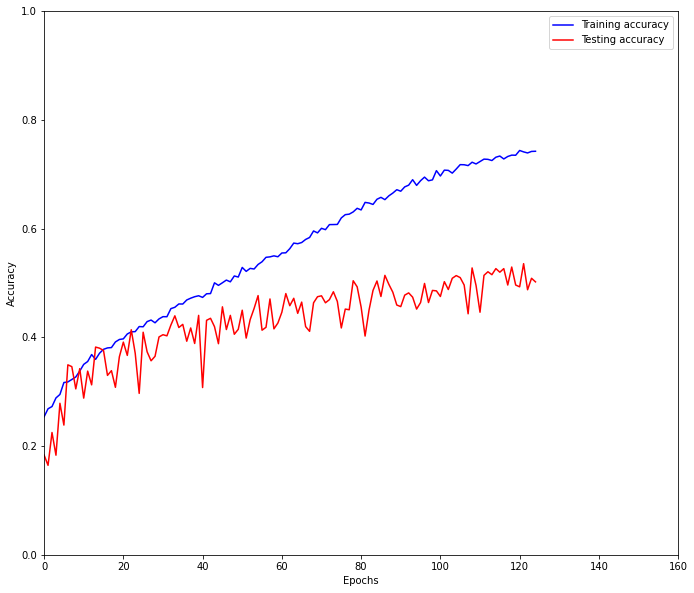

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 160, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [42]:
history={}
history["history"] = pd.read_csv(file_path_model+'source_history_1.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.745968,0.639878,0.505790,1.581918
1,1,0.741729,0.643775,0.498346,1.661505
2,2,0.749483,0.639963,0.488007,1.691992
3,3,0.749380,0.636314,0.492969,1.645943
4,4,0.750000,0.630276,0.452026,1.997277


Text(0, 0.5, 'Accuracy')

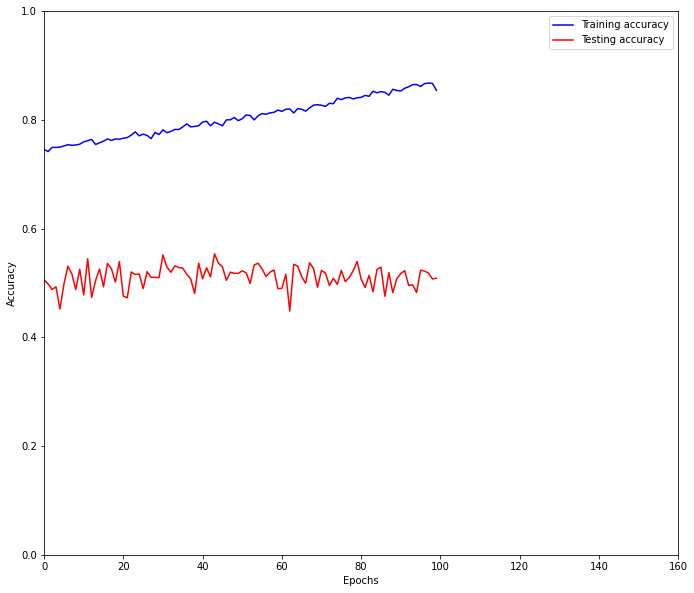

In [43]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 160, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [44]:
y_test.shape

(2418, 7)

In [45]:
y_pred.shape

(2418, 7)

In [46]:
y_pred1=np.around(y_pred)
y_pred1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
y_pred1.shape

(2418, 7)

In [48]:
# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(y_test,y_pred1)}")

Accuracy of the classifier is: 0.44995864350703063


In [49]:
gfcc_dict={"y_test_gfcc":y_test,"y_pred_gfcc":y_pred1}
gfcc_dict

{'y_pred_gfcc': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'y_test_gfcc': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)}

In [50]:
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(y_test,y_pred1,average='micro')}")

Precision Score of the classifier is: 0.5978021978021978


In [51]:
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(y_test, y_pred1,average='micro')}")

F1 Score of the classifier is: 0.5134497404436056


In [52]:
y_pred1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [53]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [54]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [55]:
pickle.dump(gfcc_dict, open(file_path_model+'gfcc_dict_values.p', 'wb'))

In [ ]:
!pip install keras
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored